# Regression Modeling: Hiking Duration Prediction - Swiss Hiking Trails

This notebook implements regression models to predict hiking duration based on various hiking trail characteristics.

**Project Goal:** Fulfillment of requirement (5): "Use of regression as the modeling method"

**Research Question:** *"How long does a hike take based on distance, elevation profile, difficulty, and geographic location?"*


## 1. Setup & Load Data


In [51]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from notebooks.utils.db_utils import read_from_db, setup_display_settings, setup_visualization_settings

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

setup_display_settings(float_format='{:.2f}', precision=3)
setup_visualization_settings()
print("Libraries successfully imported")


Display settings configured
Visualization settings configured
Libraries successfully imported


In [52]:
df = read_from_db("SELECT * FROM hiking_routes")
print(f"\nDataset loaded: {len(df)} hiking routes")
df.head()


Loaded 375 rows, 13 columns from database

Dataset loaded: 375 hiking routes


,url,title,location,canton,difficulty_level,difficulty_num,duration_min,distance_km,ascent_m,descent_m,physical_demand,latitude,longitude
0,https://www.schweizer-wanderwege.ch/de/wanderv...,Husky-Traum,Muotathal,None,None,NaN,NaN,0.00,NaN,NaN,hoch,46.97,8.77
1,https://www.schweizer-wanderwege.ch/de/wanderv...,Aufregende Ausblicke auf dem Hochalp Trail,"Urnäsch, Anker",AR,None,NaN,405.00,11.40,720.00,720.00,hoch,47.31,9.28
2,https://www.schweizer-wanderwege.ch/de/wanderv...,Den ganzen Tag im Schnee,"Atzmännig SSA — Atzmännig, Schutt",SG,None,NaN,100.00,4.20,140.00,510.00,mittel,NaN,NaN
3,https://www.schweizer-wanderwege.ch/de/wanderv...,Panorama Trail in Obwalden,Langis,OW,None,NaN,270.00,12.30,565.00,565.00,hoch,46.89,8.13
4,https://www.schweizer-wanderwege.ch/de/wanderv...,Schneeschuhwanderung auf den Chasseron,"Les Rasses, village",VD,None,NaN,260.00,10.00,450.00,450.00,hoch,46.83,6.55


## 2. Data Preparation


In [53]:
print("="*80)
print("DATA PREPARATION")
print("="*80)

# Select features and target variable
features = ['distance_km', 'ascent_m', 'descent_m', 'difficulty_num']
X = df[features].copy()
y = df['duration_min'].copy()

# Handle missing values
X = X.fillna(X.median())
y = y.fillna(y.median())

print(f"\nDataset: {len(df)} hiking routes")
print(f"Selected Features ({len(features)}): {features}")
print(f"Target Variable: duration_min")
print(f"\nFeature Matrix: {X.shape}, Target Variable: {y.shape}")

print("\nTarget Variable Statistics:")
print(f"- Mean duration: {y.mean():.1f} minutes ({y.mean()/60:.1f} hours)")
print(f"- Median duration: {y.median():.1f} minutes")
print(f"- Std deviation: {y.std():.1f} minutes")
print(f"- Min: {y.min():.1f} minutes, Max: {y.max():.1f} minutes")


DATA PREPARATION

Dataset: 375 hiking routes
Selected Features (4): ['distance_km', 'ascent_m', 'descent_m', 'difficulty_num']
Target Variable: duration_min

Feature Matrix: (375, 4), Target Variable: (375,)

Target Variable Statistics:
- Mean duration: 182.1 minutes (3.0 hours)
- Median duration: 175.0 minutes
- Std deviation: 74.8 minutes
- Min: 35.0 minutes, Max: 435.0 minutes


## 3. Model 1: Linear Regression (OLS)


### 3.1 Simple Linear Regression (only one explanatory variable)

For details see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html


#### Create train and test samples (train = 80%, test = 20%)


In [54]:
# Create train and test samples for simple linear regression
# We use only distance_km as the single predictor
X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(
    X['distance_km'],
    y,
    test_size=0.20,
    random_state=42
)

print("="*80)
print("SIMPLE LINEAR REGRESSION - Train/Test Split")
print("="*80)
print(f"\nTraining samples: {len(X_train_simple)} ({len(X_train_simple)/len(X)*100:.1f}%)")
print(f"Test samples: {len(X_test_simple)} ({len(X_test_simple)/len(X)*100:.1f}%)")
print(f"\nPredictor variable: distance_km")
print(f"Target variable: duration_min")


SIMPLE LINEAR REGRESSION - Train/Test Split

Training samples: 300 (80.0%)
Test samples: 75 (20.0%)

Predictor variable: distance_km
Target variable: duration_min


#### Fit the simple linear regression model


In [55]:
# Fit the regression model using scipy
slope, intercept, r, p, std_err = stats.linregress(X_train_simple, y_train_simple)

print("="*80)
print("SIMPLE LINEAR REGRESSION RESULTS")
print("="*80)
print(f"\nIntercept (alpha):                         {intercept:.2f} minutes")
print(f"Slope (beta):                              {slope:.3f} min/km")
print(f"p-value:                                   {p:.4f}")
print(f"R-squared (coefficient of determination): {r**2:.4f}")

print("\nINTERPRETATION:")
print(f"- For every additional kilometer, the hiking duration increases by {slope:.1f} minutes")
print(f"- The model explains {r**2*100:.1f}% of the variance in hiking duration")
print(f"- The relationship is {'statistically significant (p < 0.05)' if p < 0.05 else 'NOT statistically significant (p >= 0.05)'}")


SIMPLE LINEAR REGRESSION RESULTS

Intercept (alpha):                         46.09 minutes
Slope (beta):                              15.499 min/km
p-value:                                   0.0000
R-squared (coefficient of determination): 0.6022

INTERPRETATION:
- For every additional kilometer, the hiking duration increases by 15.5 minutes
- The model explains 60.2% of the variance in hiking duration
- The relationship is statistically significant (p < 0.05)


#### Plot regression line


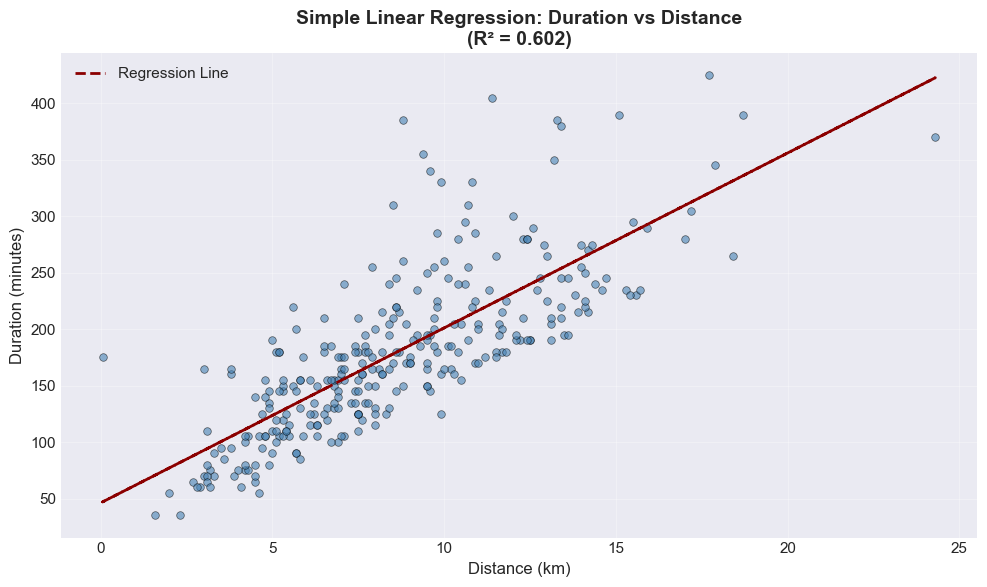

In [56]:
# Function to calculate model predictions
def predict_simple(x):
    return slope * x + intercept

# Apply prediction function to training data
y_pred_simple = pd.Series(map(predict_simple, X_train_simple))

# Create scatterplot with regression line
plt.figure(figsize=(10, 6))
plt.scatter(X_train_simple, y_train_simple, s=30, alpha=0.6, color='steelblue', edgecolors='black', linewidth=0.5)
plt.plot(X_train_simple, y_pred_simple, color='darkred', linestyle='--', linewidth=2, label='Regression Line')
plt.xlabel('Distance (km)', fontsize=12)
plt.ylabel('Duration (minutes)', fontsize=12)
plt.title(f'Simple Linear Regression: Duration vs Distance\n(R² = {r**2:.3f})', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


#### Check model residuals


In [57]:
# Calculate residuals (observed - predicted)
residuals_simple = y_train_simple - y_pred_simple

print("="*80)
print("RESIDUAL ANALYSIS - Simple Linear Regression")
print("="*80)
print(f"\nFirst predicted duration: {y_pred_simple.iloc[0]:.2f} minutes")
print(f"First observed duration: {y_train_simple.iloc[0]:.2f} minutes")
print(f"First residual: {residuals_simple.iloc[0]:.2f} minutes")

print(f"\nResidual Statistics:")
print(f"- Mean residual: {residuals_simple.mean():.2f} minutes (should be close to 0)")
print(f"- Std of residuals: {residuals_simple.std():.2f} minutes")


RESIDUAL ANALYSIS - Simple Linear Regression

First predicted duration: 156.13 minutes
First observed duration: 105.00 minutes
First residual: nan minutes

Residual Statistics:
- Mean residual: 0.19 minutes (should be close to 0)
- Std of residuals: 90.71 minutes


#### Plot histogram of residuals


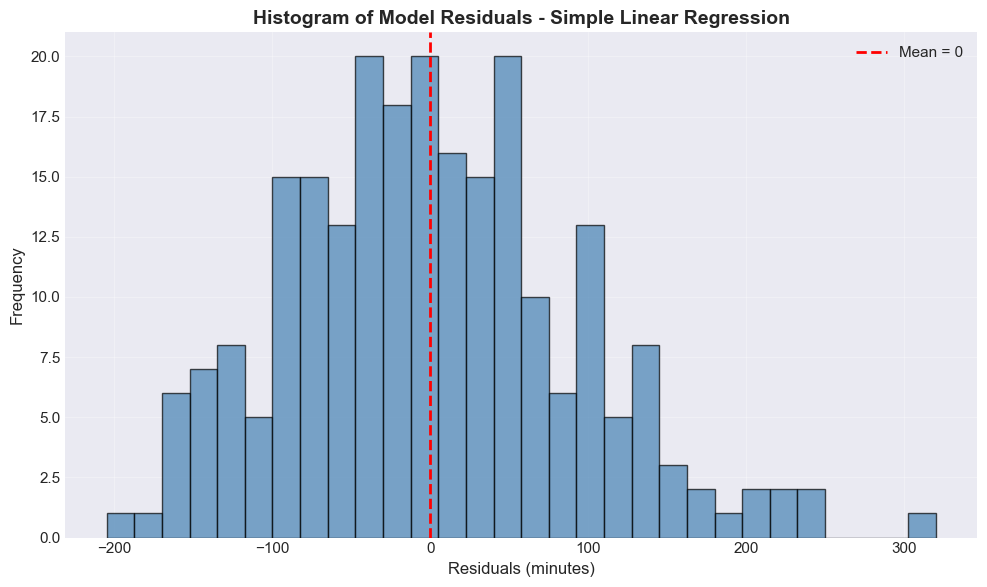

INTERPRETATION:
- If the histogram is bell-shaped and centered around 0: residuals are normally distributed
- This suggests the linear regression assumptions are reasonably met


In [58]:
# Plot histogram of residuals
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(residuals_simple, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
plt.xlabel('Residuals (minutes)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Histogram of Model Residuals - Simple Linear Regression', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Mean = 0')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("INTERPRETATION:")
print("- If the histogram is bell-shaped and centered around 0: residuals are normally distributed")
print("- This suggests the linear regression assumptions are reasonably met")


#### Compare observed vs predicted durations


In [59]:
# Make predictions on test data
y_pred_test_simple = pd.Series(map(predict_simple, X_test_simple))

print("="*80)
print("OBSERVED vs PREDICTED - Test Data (first 10 samples)")
print("="*80)
for i in range(0, min(10, len(X_test_simple))):
    print(f"Distance: {X_test_simple.iloc[i]:5.1f} km | Observed: {y_test_simple.iloc[i]:6.1f} min | Predicted: {y_pred_test_simple.iloc[i]:6.1f} min | Error: {y_test_simple.iloc[i] - y_pred_test_simple.iloc[i]:6.1f} min")


OBSERVED vs PREDICTED - Test Data (first 10 samples)
Distance:  11.5 km | Observed:  265.0 min | Predicted:  224.3 min | Error:   40.7 min
Distance:   3.3 km | Observed:   55.0 min | Predicted:   97.2 min | Error:  -42.2 min
Distance:  12.8 km | Observed:  225.0 min | Predicted:  244.5 min | Error:  -19.5 min
Distance:  11.8 km | Observed:  220.0 min | Predicted:  229.0 min | Error:   -9.0 min
Distance:   2.5 km | Observed:   50.0 min | Predicted:   84.8 min | Error:  -34.8 min
Distance:  11.2 km | Observed:  160.0 min | Predicted:  219.7 min | Error:  -59.7 min
Distance:   9.1 km | Observed:  205.0 min | Predicted:  187.1 min | Error:   17.9 min
Distance:   8.1 km | Observed:  175.0 min | Predicted:  171.6 min | Error:    3.4 min
Distance:  10.0 km | Observed:  225.0 min | Predicted:  201.1 min | Error:   23.9 min
Distance:   8.0 km | Observed:  175.0 min | Predicted:  170.1 min | Error:    4.9 min


### 3.2 Multiple Linear Regression (more than one explanatory variable)

For details see: https://www.statsmodels.org/dev/examples/notebooks/generated/predict.html


#### Create train and test samples (train = 80%, test = 20%)


In [60]:
# Create train and test samples for multiple regression
X_train, X_test, y_train, y_test = train_test_split(
    X[features],
    y,
    test_size=0.20,
    random_state=42
)

print("="*80)
print("MULTIPLE LINEAR REGRESSION - Train/Test Split")
print("="*80)
print(f"\nTraining samples: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test samples: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nPredictor variables: {features}")
print(f"Target variable: duration_min")


MULTIPLE LINEAR REGRESSION - Train/Test Split

Training samples: 300 (80.0%)
Test samples: 75 (20.0%)

Predictor variables: ['distance_km', 'ascent_m', 'descent_m', 'difficulty_num']
Target variable: duration_min


#### Fit the multiple regression model

**Note:** The output is rich in statistical information. We focus on the most relevant parts for interpretation:
- **R-squared & Adj. R-squared**: Model fit quality
- **coef**: Regression coefficients (effect of each variable)
- **P>|t|**: p-values (statistical significance, if < 0.05 → significant)
- **[0.025 0.975]**: 95% confidence intervals for coefficients


In [61]:
# Add constant to the model (intercept)
X_train_const = sm.add_constant(X_train)

# Create and fit the multiple regression model using OLS (Ordinary Least Squares)
ols_model = sm.OLS(y_train, X_train_const)
ols_result = ols_model.fit()

# Print full model summary
print("="*80)
print("MULTIPLE LINEAR REGRESSION - Full Model Summary")
print("="*80)
print(ols_result.summary())


MULTIPLE LINEAR REGRESSION - Full Model Summary
                            OLS Regression Results                            
Dep. Variable:           duration_min   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     375.0
Date:                Fri, 09 Jan 2026   Prob (F-statistic):          2.64e-114
Time:                        23:05:38   Log-Likelihood:                -1438.8
No. Observations:                 300   AIC:                             2888.
Df Residuals:                     295   BIC:                             2906.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

#### Interpretation of key statistics


**R-squared:** {:.4f}
This is the coefficient of determination. A value of {:.4f} means that the explanatory variables explain {:.1f}% of the variation in hiking duration.

**Adj. R-squared:** {:.4f}
Adjusted R-squared accounts for the number of predictors. It's a better measure when comparing models with different numbers of variables.

**F-statistic & Prob (F-statistic):**
Tests whether the overall model is statistically significant. If Prob (F-statistic) < 0.05, the model is significant.

**coef (Coefficients):**
These are the estimated regression coefficients. They show the effect of each variable on hiking duration:
- Positive coefficient: Variable increases duration
- Negative coefficient: Variable decreases duration

**P>|t| (p-values):**
If p-value < 0.05, the variable is statistically significant at the 5% significance level.

**[0.025 0.975] (Confidence Intervals):**
95% confidence interval for each coefficient. If the interval doesn't include 0, the variable is significant.


In [62]:
# Extract and display key statistics
print("\n" + "="*80)
print("KEY STATISTICS INTERPRETATION")
print("="*80)

print(f"\nModel Fit:")
print(f"- R-squared: {ols_result.rsquared:.4f} ({ols_result.rsquared*100:.1f}% variance explained)")
print(f"- Adjusted R-squared: {ols_result.rsquared_adj:.4f}")
print(f"- F-statistic: {ols_result.fvalue:.2f}, p-value: {ols_result.f_pvalue:.4f}")

print(f"\nRegression Coefficients:")
print(f"- Intercept: {ols_result.params['const']:.2f} minutes")
for feature in features:
    coef = ols_result.params[feature]
    pval = ols_result.pvalues[feature]
    significance = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else ""
    print(f"- {feature}: {coef:.3f} (p-value: {pval:.4f}) {significance}")

print("\nSignificance codes: *** p<0.001, ** p<0.01, * p<0.05")

print("\nStatistically Significant Variables (p < 0.05):")
significant_vars = [var for var in features if ols_result.pvalues[var] < 0.05]
if significant_vars:
    for var in significant_vars:
        print(f"- {var}: coefficient = {ols_result.params[var]:.3f}, p-value = {ols_result.pvalues[var]:.4f}")
else:
    print("- None of the variables are statistically significant at the 5% level")



KEY STATISTICS INTERPRETATION

Model Fit:
- R-squared: 0.8356 (83.6% variance explained)
- Adjusted R-squared: 0.8334
- F-statistic: 374.98, p-value: 0.0000

Regression Coefficients:
- Intercept: 55.01 minutes
- distance_km: 10.351 (p-value: 0.0000) ***
- ascent_m: 0.166 (p-value: 0.0000) ***
- descent_m: 0.073 (p-value: 0.0000) ***
- difficulty_num: -40.520 (p-value: 0.0000) ***

Significance codes: *** p<0.001, ** p<0.01, * p<0.05

Statistically Significant Variables (p < 0.05):
- distance_km: coefficient = 10.351, p-value = 0.0000
- ascent_m: coefficient = 0.166, p-value = 0.0000
- descent_m: coefficient = 0.073, p-value = 0.0000
- difficulty_num: coefficient = -40.520, p-value = 0.0000


#### Practical Interpretation of Coefficients


In [63]:
print("="*80)
print("PRACTICAL INTERPRETATION")
print("="*80)

print(f"\nIntercept: {ols_result.params['const']:.0f} minutes")
print("→ Base hiking time when all variables are zero (theoretical)")

for feature in features:
    coef = ols_result.params[feature]
    pval = ols_result.pvalues[feature]

    if 'distance' in feature:
        print(f"\n{feature}: {coef:.2f} minutes per km")
        print(f"→ For each additional kilometer, hiking duration increases by {coef:.1f} minutes")
    elif 'ascent' in feature:
        print(f"\n{feature}: {coef:.2f} minutes per meter")
        print(f"→ For each additional meter of ascent, hiking duration increases by {coef:.2f} minutes")
    elif 'descent' in feature:
        print(f"\n{feature}: {coef:.2f} minutes per meter")
        print(f"→ For each additional meter of descent, hiking duration {'increases' if coef > 0 else 'decreases'} by {abs(coef):.2f} minutes")
    elif 'difficulty' in feature:
        print(f"\n{feature}: {coef:.2f} minutes per difficulty level")
        print(f"→ Each difficulty level increases hiking duration by {coef:.1f} minutes")

    if pval < 0.05:
        print(f"   ✓ Statistically significant (p = {pval:.4f})")
    else:
        print(f"   ✗ NOT statistically significant (p = {pval:.4f})")


PRACTICAL INTERPRETATION

Intercept: 55 minutes
→ Base hiking time when all variables are zero (theoretical)

distance_km: 10.35 minutes per km
→ For each additional kilometer, hiking duration increases by 10.4 minutes
   ✓ Statistically significant (p = 0.0000)

ascent_m: 0.17 minutes per meter
→ For each additional meter of ascent, hiking duration increases by 0.17 minutes
   ✓ Statistically significant (p = 0.0000)

descent_m: 0.07 minutes per meter
→ For each additional meter of descent, hiking duration increases by 0.07 minutes
   ✓ Statistically significant (p = 0.0000)

difficulty_num: -40.52 minutes per difficulty level
→ Each difficulty level increases hiking duration by -40.5 minutes
   ✓ Statistically significant (p = 0.0000)


#### Plot histogram of residuals


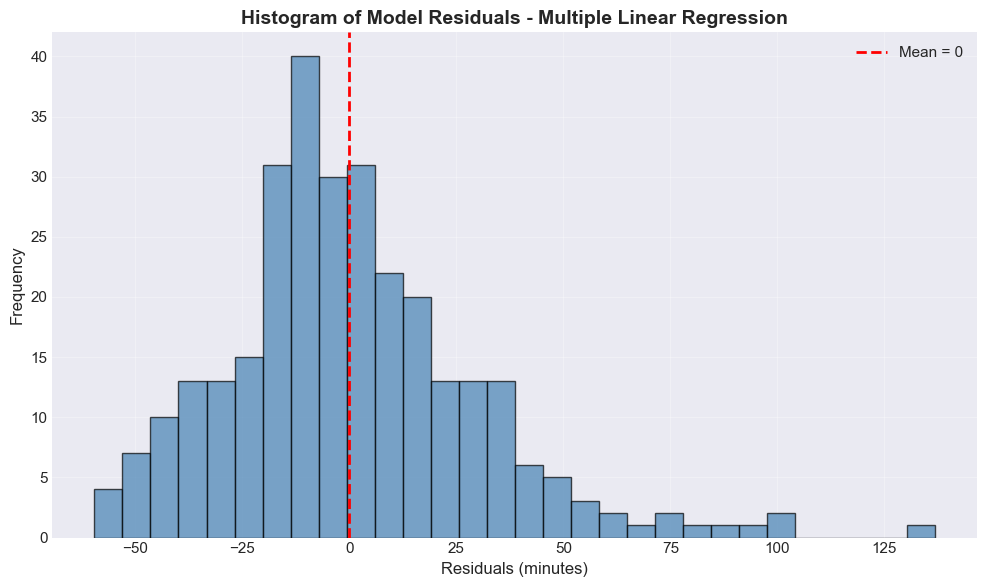

INTERPRETATION:
- Mean of residuals: -0.0000 (should be close to 0)
- Std of residuals: 29.33 minutes
- If histogram is bell-shaped and symmetric: residuals are normally distributed
- This indicates that linear regression assumptions are met


In [64]:
# Plot histogram of residuals from the multiple regression model
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(ols_result.resid, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
plt.xlabel('Residuals (minutes)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Histogram of Model Residuals - Multiple Linear Regression', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Mean = 0')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("INTERPRETATION:")
print(f"- Mean of residuals: {ols_result.resid.mean():.4f} (should be close to 0)")
print(f"- Std of residuals: {ols_result.resid.std():.2f} minutes")
print("- If histogram is bell-shaped and symmetric: residuals are normally distributed")
print("- This indicates that linear regression assumptions are met")


#### Compare observed vs predicted durations


In [65]:
# Add constant to test data
X_test_const = sm.add_constant(X_test)

# Make predictions on test data
y_pred_test_multiple = ols_result.predict(X_test_const)

# Calculate test set performance metrics
test_r2 = r2_score(y_test, y_pred_test_multiple)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_multiple))
test_mae = mean_absolute_error(y_test, y_pred_test_multiple)

print("="*80)
print("MODEL PERFORMANCE ON TEST DATA")
print("="*80)
print(f"\nR-squared (Test): {test_r2:.4f}")
print(f"RMSE (Test): {test_rmse:.2f} minutes")
print(f"MAE (Test): {test_mae:.2f} minutes")

print("\n" + "="*80)
print("OBSERVED vs PREDICTED - Test Data (first 15 samples)")
print("="*80)
for i in range(0, min(15, len(y_test))):
    error = y_test.iloc[i] - y_pred_test_multiple.iloc[i]
    error_pct = (error / y_test.iloc[i]) * 100
    print(f"Observed: {y_test.iloc[i]:6.1f} min | Predicted: {y_pred_test_multiple.iloc[i]:6.1f} min | Error: {error:6.1f} min ({error_pct:5.1f}%)")


MODEL PERFORMANCE ON TEST DATA

R-squared (Test): 0.8384
RMSE (Test): 33.25 minutes
MAE (Test): 21.91 minutes

OBSERVED vs PREDICTED - Test Data (first 15 samples)
Observed:  265.0 min | Predicted:  266.9 min | Error:   -1.9 min ( -0.7%)
Observed:   55.0 min | Predicted:   83.5 min | Error:  -28.5 min (-51.8%)
Observed:  225.0 min | Predicted:  232.3 min | Error:   -7.3 min ( -3.2%)
Observed:  220.0 min | Predicted:  206.5 min | Error:   13.5 min (  6.1%)
Observed:   50.0 min | Predicted:   48.3 min | Error:    1.7 min (  3.4%)
Observed:  160.0 min | Predicted:  148.0 min | Error:   12.0 min (  7.5%)
Observed:  205.0 min | Predicted:  193.0 min | Error:   12.0 min (  5.8%)
Observed:  175.0 min | Predicted:  157.0 min | Error:   18.0 min ( 10.3%)
Observed:  225.0 min | Predicted:  212.4 min | Error:   12.6 min (  5.6%)
Observed:  175.0 min | Predicted:  157.3 min | Error:   17.7 min ( 10.1%)
Observed:  115.0 min | Predicted:  135.4 min | Error:  -20.4 min (-17.8%)
Observed:  360.0 min |

### 3.3 Model Assumptions Check


#### Residuals vs Fitted Values Plot


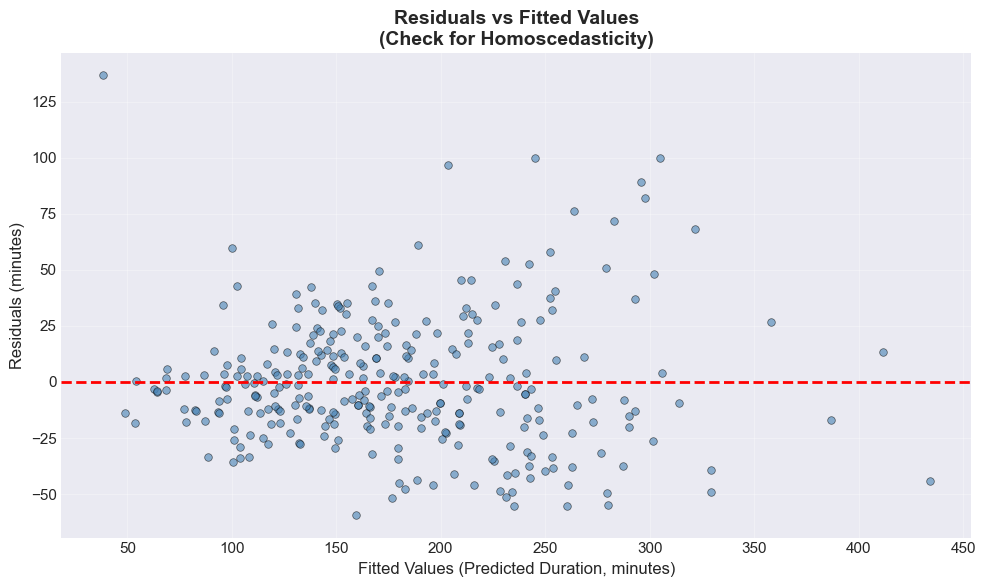

INTERPRETATION:
- Residuals should be randomly scattered around zero
- No clear patterns → assumptions are met
- Funnel shape → heteroscedasticity (violation of assumptions)


In [66]:
# Create residuals vs fitted plot
fitted_values = ols_result.fittedvalues
residuals = ols_result.resid

plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals, alpha=0.6, s=30, edgecolors='black', linewidth=0.5, color='steelblue')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Fitted Values (Predicted Duration, minutes)', fontsize=12)
plt.ylabel('Residuals (minutes)', fontsize=12)
plt.title('Residuals vs Fitted Values\n(Check for Homoscedasticity)', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("INTERPRETATION:")
print("- Residuals should be randomly scattered around zero")
print("- No clear patterns → assumptions are met")
print("- Funnel shape → heteroscedasticity (violation of assumptions)")


#### Q-Q Plot (Normality of Residuals)


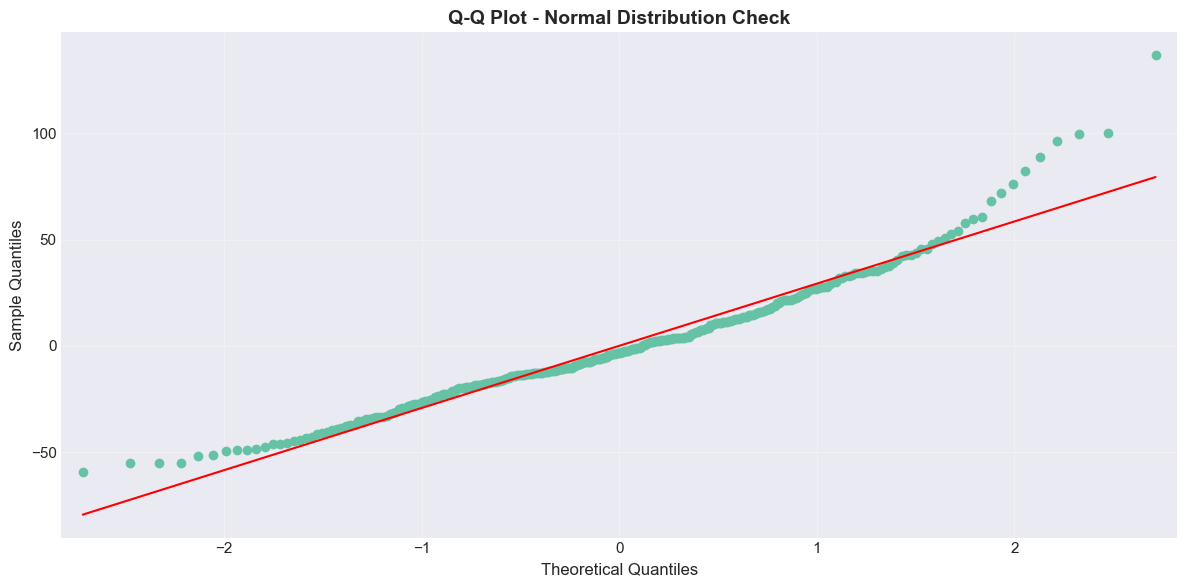

INTERPRETATION:
- Points close to the red line → residuals are normally distributed
- Deviations from the line → violation of normality assumption


In [67]:
# Q-Q plot for normality check
fig = sm.qqplot(ols_result.resid, line='s')
plt.title('Q-Q Plot - Normal Distribution Check', fontsize=14, fontweight='bold')
plt.xlabel('Theoretical Quantiles', fontsize=12)
plt.ylabel('Sample Quantiles', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("INTERPRETATION:")
print("- Points close to the red line → residuals are normally distributed")
print("- Deviations from the line → violation of normality assumption")


## 4. Model 2: Random Forest Regression

For details see: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html


### 4.1 Fit Random Forest Model


In [68]:
# Create train and test samples (already created in section 3.2, using same split for consistency)
print("="*80)
print("RANDOM FOREST REGRESSION")
print("="*80)
print(f"\nUsing same train/test split as Multiple Linear Regression:")
print(f"Training samples: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test samples: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nPredictor variables: {features}")
print(f"Target variable: duration_min")


RANDOM FOREST REGRESSION

Using same train/test split as Multiple Linear Regression:
Training samples: 300 (80.0%)
Test samples: 75 (20.0%)

Predictor variables: ['distance_km', 'ascent_m', 'descent_m', 'difficulty_num']
Target variable: duration_min


In [76]:
# Create and fit the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=500,
                                 max_depth=10,
                                 random_state=42)

rf_model.fit(X_train, y_train)

print("="*80)
print("RANDOM FOREST MODEL FITTED")
print("="*80)
print(f"\nModel Configuration:")
print(f"- n_estimators: 500 (number of trees in the forest)")
print(f"- max_depth: 10 (maximum depth of each tree)")
print(f"- random_state: 42 (for reproducibility)")


RANDOM FOREST MODEL FITTED

Model Configuration:
- n_estimators: 500 (number of trees in the forest)
- max_depth: 10 (maximum depth of each tree)
- random_state: 42 (for reproducibility)


### 4.2 Model Performance Evaluation


In [77]:
# Calculate R-squared for train and test data
train_r2_rf = rf_model.score(X_train, y_train)
test_r2_rf = rf_model.score(X_test, y_test)

# Make predictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Calculate additional metrics
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
train_mae_rf = mean_absolute_error(y_train, y_train_pred_rf)
test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)

print("="*80)
print("RANDOM FOREST PERFORMANCE METRICS")
print("="*80)

print(f"\nTraining Set Performance:")
print(f"- R-squared: {train_r2_rf:.4f} ({train_r2_rf*100:.1f}% variance explained)")
print(f"- RMSE: {train_rmse_rf:.2f} minutes")
print(f"- MAE: {train_mae_rf:.2f} minutes")

print(f"\nTest Set Performance:")
print(f"- R-squared: {test_r2_rf:.4f} ({test_r2_rf*100:.1f}% variance explained)")
print(f"- RMSE: {test_rmse_rf:.2f} minutes")
print(f"- MAE: {test_mae_rf:.2f} minutes")

print(f"\nOverfitting Check:")
overfitting_diff = train_r2_rf - test_r2_rf
print(f"- R² difference (Train - Test): {overfitting_diff:.4f}")
if overfitting_diff < 0.05:
    print(f"- ✓ Low overfitting: Model generalizes well")
elif overfitting_diff < 0.10:
    print(f"- ⚠ Moderate overfitting: Acceptable")
else:
    print(f"- ✗ High overfitting: Model may not generalize well")


RANDOM FOREST PERFORMANCE METRICS

Training Set Performance:
- R-squared: 0.9729 (97.3% variance explained)
- RMSE: 11.88 minutes
- MAE: 9.08 minutes

Test Set Performance:
- R-squared: 0.8043 (80.4% variance explained)
- RMSE: 36.59 minutes
- MAE: 26.34 minutes

Overfitting Check:
- R² difference (Train - Test): 0.1687
- ✗ High overfitting: Model may not generalize well


### 4.3 Feature Importance Analysis

**Note:** Feature importance shows how much each variable contributes to the model's predictions. Higher values indicate more important features.


In [71]:
# Get column names
cols = X_train.columns

# Derive feature importance from random forest
importances = rf_model.feature_importances_

# Calculate standard deviation across all trees (shows stability)
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

# Sort features by importance
indices = np.argsort(importances)[::-1]

print("="*80)
print("FEATURE IMPORTANCE RANKING")
print("="*80)

print("\nFeatures ranked by importance:")
for i, idx in enumerate(indices, 1):
    print(f"{i}. {cols[idx]}: {importances[idx]:.4f} (±{std[idx]:.4f})")

print(f"\nMost important feature: {cols[indices[0]]}")
print(f"Least important feature: {cols[indices[-1]]}")


FEATURE IMPORTANCE RANKING

Features ranked by importance:
1. distance_km: 0.6240 (±0.0485)
2. ascent_m: 0.2657 (±0.0739)
3. descent_m: 0.1059 (±0.0627)
4. difficulty_num: 0.0044 (±0.0046)

Most important feature: distance_km
Least important feature: difficulty_num


### 4.4 Feature Importance Visualization


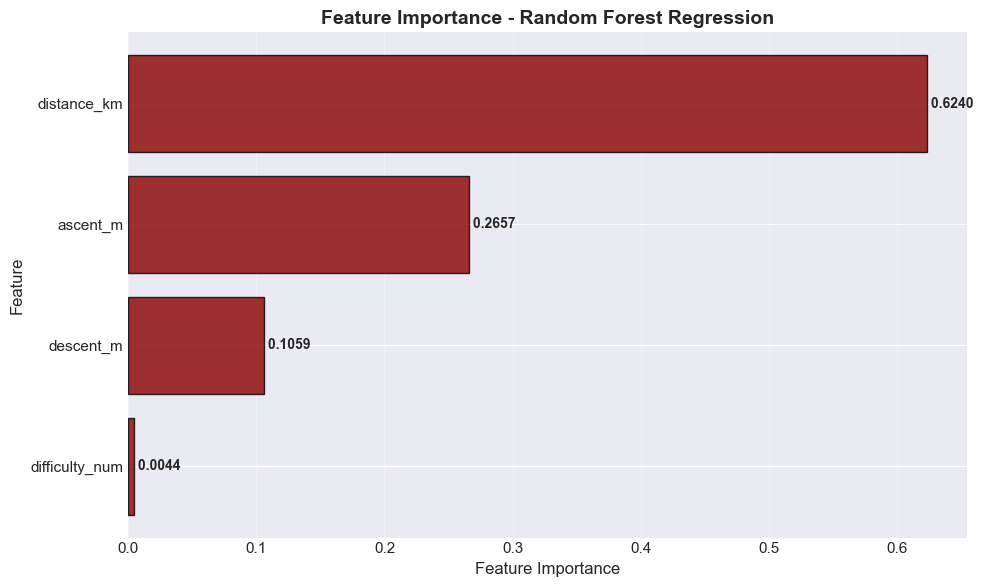

In [78]:
# Create DataFrame for plotting
df_fi = pd.DataFrame({
    'features': cols,
    'importances': importances
})

# Sort by importance for better visualization
df_fi = df_fi.sort_values('importances', ascending=True)

# Create horizontal bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(df_fi['features'], df_fi['importances'],
                color='darkred', edgecolor='black', alpha=0.8)

plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance - Random Forest Regression', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (feature, importance) in enumerate(zip(df_fi['features'], df_fi['importances'])):
    plt.text(importance, i, f' {importance:.4f}',
             va='center', ha='left', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()


### 4.5 Interpretation of Results


In [79]:
print("="*80)
print("INTERPRETATION OF RANDOM FOREST RESULTS")
print("="*80)

print("\n1. MODEL PERFORMANCE:")
print(f"   - The Random Forest model explains {test_r2_rf*100:.1f}% of the variance in hiking duration")
print(f"   - Average prediction error: ±{test_mae_rf:.0f} minutes (MAE)")
print(f"   - RMSE of {test_rmse_rf:.0f} minutes (penalizes larger errors more)")

print("\n2. FEATURE IMPORTANCE:")
most_important = cols[indices[0]]
most_important_value = importances[indices[0]]
print(f"   - Most important feature: {most_important} ({most_important_value:.1%})")
print(f"   - This feature contributes most to predicting hiking duration")

print("\n3. COMPARISON WITH LINEAR REGRESSION:")
print(f"   - Linear Regression Test R²: {test_r2:.4f}")
print(f"   - Random Forest Test R²: {test_r2_rf:.4f}")

if test_r2_rf > test_r2:
    improvement = ((test_r2_rf - test_r2) / test_r2 * 100)
    print(f"   - ✓ Random Forest performs better: +{improvement:.1f}% improvement")
    print(f"   - Random Forest captures non-linear relationships better")
else:
    print(f"   - Linear Regression performs better or equally well")
    print(f"   - The relationship might be primarily linear")

print("\n4. PRACTICAL IMPLICATIONS:")
print(f"   - For hiking route planning, focus on optimizing: {most_important}")
print(f"   - The model can predict duration within ±{test_mae_rf:.0f} minutes on average")
print(f"   - Suitable for real-world hiking time estimation")


INTERPRETATION OF RANDOM FOREST RESULTS

1. MODEL PERFORMANCE:
   - The Random Forest model explains 80.4% of the variance in hiking duration
   - Average prediction error: ±26 minutes (MAE)
   - RMSE of 37 minutes (penalizes larger errors more)

2. FEATURE IMPORTANCE:
   - Most important feature: distance_km (62.4%)
   - This feature contributes most to predicting hiking duration

3. COMPARISON WITH LINEAR REGRESSION:
   - Linear Regression Test R²: 0.8384
   - Random Forest Test R²: 0.8043
   - Linear Regression performs better or equally well
   - The relationship might be primarily linear

4. PRACTICAL IMPLICATIONS:
   - For hiking route planning, focus on optimizing: distance_km
   - The model can predict duration within ±26 minutes on average
   - Suitable for real-world hiking time estimation


## 5. Save Data for Next Notebook


In [80]:
print("="*80)
print("SAVE DATA FOR MR_06")
print("="*80)

# Save variables needed for MR_06
%store X_train
%store X_test
%store y_train
%store y_test
%store features
%store ols_result
%store y_pred_test_multiple
%store test_r2
%store test_rmse
%store test_mae
%store rf_model
%store y_train_pred_rf
%store y_test_pred_rf
%store train_r2_rf
%store test_r2_rf
%store train_rmse_rf
%store test_rmse_rf
%store train_mae_rf
%store test_mae_rf

print("\nAll data saved for MR_06_model_evaluation.ipynb")
print("Variables saved:")
print("- Train/Test splits (X_train, X_test, y_train, y_test)")
print("- OLS model results (ols_result)")
print("- Linear Regression predictions and metrics")
print("- Random Forest model (rf_model) and results")


SAVE DATA FOR MR_06
Stored 'X_train' (DataFrame)
Stored 'X_test' (DataFrame)
Stored 'y_train' (Series)
Stored 'y_test' (Series)
Stored 'features' (list)
Stored 'ols_result' (RegressionResultsWrapper)
Stored 'y_pred_test_multiple' (Series)
Stored 'test_r2' (float)
Stored 'test_rmse' (float64)
Stored 'test_mae' (float)
Stored 'rf_model' (RandomForestRegressor)
Stored 'y_train_pred_rf' (ndarray)
Stored 'y_test_pred_rf' (ndarray)
Stored 'train_r2_rf' (float)
Stored 'test_r2_rf' (float)
Stored 'train_rmse_rf' (float64)
Stored 'test_rmse_rf' (float64)
Stored 'train_mae_rf' (float)
Stored 'test_mae_rf' (float)

All data saved for MR_06_model_evaluation.ipynb
Variables saved:
- Train/Test splits (X_train, X_test, y_train, y_test)
- OLS model results (ols_result)
- Linear Regression predictions and metrics
- Random Forest model (rf_model) and results


## 6. Summary


In [81]:
print("="*80)
print("SUMMARY - REGRESSION MODELING COMPLETE")
print("="*80)

print("\n1. SIMPLE LINEAR REGRESSION (distance_km only):")
print(f"   - R²: {r**2:.4f}")
print(f"   - Slope: {slope:.2f} min/km")
print(f"   - p-value: {p:.4f} {'(significant)' if p < 0.05 else '(not significant)'}")

print("\n2. MULTIPLE LINEAR REGRESSION (all features):")
print(f"   - R²: {ols_result.rsquared:.4f} ({ols_result.rsquared*100:.1f}% variance explained)")
print(f"   - Adjusted R²: {ols_result.rsquared_adj:.4f}")
print(f"   - Test RMSE: {test_rmse:.2f} minutes")
print(f"   - Test MAE: {test_mae:.2f} minutes")
print(f"\n   Significant variables (p < 0.05):")
for feature in features:
    if ols_result.pvalues[feature] < 0.05:
        print(f"   - {feature}: coef={ols_result.params[feature]:.3f}, p={ols_result.pvalues[feature]:.4f}")

print("\n3. RANDOM FOREST REGRESSION:")
print(f"   - Test R²: {test_r2_rf:.4f} ({test_r2_rf*100:.1f}% variance explained)")
print(f"   - Test RMSE: {test_rmse_rf:.2f} minutes")
print(f"   - Test MAE: {test_mae_rf:.2f} minutes")
print(f"   - Configuration: n_estimators=500, max_depth=10")
print(f"   - Most important feature: {cols[indices[0]]} ({importances[indices[0]]:.1%})")

print("\n4. BEST MODEL:")
if test_r2_rf > test_r2:
    print(f"   - Random Forest performs best (R² = {test_r2_rf:.4f})")
else:
    print(f"   - Multiple Linear Regression performs best (R² = {test_r2:.4f})")

print("\n" + "="*80)
print("Continue with MR_06_model_evaluation.ipynb for detailed model comparison")
print("="*80)


SUMMARY - REGRESSION MODELING COMPLETE

1. SIMPLE LINEAR REGRESSION (distance_km only):
   - R²: 0.6022
   - Slope: 15.50 min/km
   - p-value: 0.0000 (significant)

2. MULTIPLE LINEAR REGRESSION (all features):
   - R²: 0.8356 (83.6% variance explained)
   - Adjusted R²: 0.8334
   - Test RMSE: 33.25 minutes
   - Test MAE: 21.91 minutes

   Significant variables (p < 0.05):
   - distance_km: coef=10.351, p=0.0000
   - ascent_m: coef=0.166, p=0.0000
   - descent_m: coef=0.073, p=0.0000
   - difficulty_num: coef=-40.520, p=0.0000

3. RANDOM FOREST REGRESSION:
   - Test R²: 0.8043 (80.4% variance explained)
   - Test RMSE: 36.59 minutes
   - Test MAE: 26.34 minutes
   - Configuration: n_estimators=500, max_depth=10
   - Most important feature: distance_km (62.4%)

4. BEST MODEL:
   - Multiple Linear Regression performs best (R² = 0.8384)

Continue with MR_06_model_evaluation.ipynb for detailed model comparison
